## Physics 129 Final Project: Higgs Discovery

In [318]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Parse the input file.  You can change to the other file by uncommenting the second line
#file = "Higgs2011.csv"
file = "Higgs2012.csv"

vtx_z = []
invariant_mass = []
ph_pt_leading = []
ph_pt_subleading = []
ph_eta_corrected_leading = []
ph_eta_corrected_subleading = []
ph_phi_leading = []
ph_phi_subleading = []
categ_Model10Categories = [] 


for line in open(file,"r"):
    line = line.strip()
    if line[0]=="#":
        print(line)
        continue
    info = line.split(",")
    vtx_z.append(info[0])
    invariant_mass.append(info[1])
    ph_pt_leading.append(info[2])
    ph_pt_subleading.append(info[3])
    ph_eta_corrected_leading.append(info[4])
    ph_eta_corrected_subleading.append(info[5])
    ph_phi_leading.append(info[6])
    ph_phi_subleading.append(info[7])
    categ_Model10Categories.append(info[8])

#
# This file contains data used in  the ATLAS Higgs discovery paper https://arxiv.org/pdf/1207.7214.pdf
# These data are the diphoton candidates from the 2012 8 TeV data taking period
# For each event, the following information is provided
#vtx_z:  The z-positon of the pp interaction in mm (center of detector is 0,0,0)
#invariant_mass:  The diphoton invariant mass in GeV
#ph_pt_leading:  Transverse momentum (in GeV)  of the highest pT photon in the event
#ph_pt_subleading: Transverse momentum (in GeV)  of the next to highest pT photon in the event
#ph_eta_corrected_leading: Pseudorapidity of the highest pT photon in the event
#ph_eta_corrected_subleading: Pseudorapidity of the next to highest pT photon in the event
#ph_phi_leading: Phi of the highest pT photon in the event
#ph_phi_subleading: Phi of the next to highest pT photon in the event
#categ_Model10Categories: Category of the event where the category is defined in Section 5.3 of the discovery paper. Categories are labeled 1 thr

In [319]:
## Import useful libraries

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sp
import scipy.stats as sps
import scipy.integrate as integrate

## Generate Category-Based Datasets

In [320]:
fulldata = []
Nd = []

cats = ['1','2','3','4','5','6','7','8','9','10']
for c in cats:
    newset = []
    mask = [p == c for p in categ_Model10Categories]
    for el in range(len(mask)):
        if mask[el] == True:
            newset.append(float(invariant_mass[el]))
    fulldata.append(newset)
    Nd.append(len(newset))
print(Nd)

inclusive7 = [fulldata[0] + fulldata[1] + fulldata[2] + fulldata[3] + fulldata[4] + fulldata[5] + fulldata[6] + fulldata[7] + fulldata[8] + fulldata[9]]

[2945, 173, 12136, 785, 2015, 113, 11099, 706, 5140, 139]


## Define Background Fit Functions

In [321]:
def B04(x):                                 # defining the 4th order Bernstein polynomials in monomial form
    return (1 - x)**4

def B14(x):
    return 4*x*((1 - x)**3)

def B24(x):
    return 6*(x**2)*((1-x)**2)

def B34(x):
    return 4*(x**3)*(1-x)

def B44(x):
    return x**4

def bernstein_combo(x,a,b,c,d,f):                                   #define 3 background fit functions
    return a*B04(x) + b*B14(x) + c*B24(x) + d*B34(x) + f*B44(x)

def exponentialfit(x,A,lamda):
    return A*np.exp(-lamda*x)

def expsquared(x,a,b,c,d):
    return (a*(x**2) + b*x + c)*np.exp(-d*x)

## Fit the Background

In [322]:
expoly = [0,4,8]
exp = [1,3,5,7,9]
poly = [2,6]
binset = np.linspace(100,160,31)
bincenters = np.linspace(101,159,30)
bkg_params = []
heightslist = []

for g in expoly:
    data = fulldata[g]
    heights = np.histogram(data,bins = binset)
    fittedpars = sp.curve_fit(expsquared,bincenters,heights[0],p0 = [0,0,0,0])
    bkg_params.append(fittedpars[0])
    heightslist.append(heights)

        
for g in exp:
    data = fulldata[g]
    heights = np.histogram(data,bins = binset)
    fittedpars = sp.curve_fit(exponentialfit,bincenters,heights[0],p0 = [0,0])
    bkg_params.append(fittedpars[0])
    heightslist.append(heights)
    
for g in poly:
    data = fulldata[g]
    heights = np.histogram(data,bins = binset)
    fittedpars = sp.curve_fit(bernstein_combo,bincenters,heights[0],p0 = [10,10,10,10,10])
    bkg_params.append(fittedpars[0])
    heightslist.append(heights)

## Model the Signal

In [323]:
scb = [1.45,1.37,1.57,1.51,1.67,1.50,1.93,1.68,2.65,1.57]        #from that loose ATLAS 2012 paper not the linked one (both sets)
sg = [3.42/2.355,3.23/2.355,3.72/2.355,3.55/2.355,3.94/2.355,3.54/2.355,4.54/2.355,3.96/2.355,6.24/2.355,3.70/2.355]     #these are FWHM/2.355 for each category

def gaussian(x,m,s):
    return (1/(s*np.sqrt(2*np.pi)))*np.exp(-((x - m)**2)/(2*(s**2)))
def gauss_sum(x,s1,s2):
    return (1/1.1)*(gaussian(x,126.5,s1) + 0.1*gaussian(x,126.5,s2))

## Calculate Number of Signal Events

In [324]:
Ns = []
#Ns_ATLAS = [10.5,1.5,21.6,2.8,6.7,1,21.1,2.7,9.5,2.2]
Ns_ATLAS = [14.2,2.5,30.9,5.2,8.9,1.6,26.9,4.5,12.8,3]
for r in range(10):
    sig_events = lambda n: (Nd[r]/35251)*50*5.9*gauss_sum(n,scb[r],sg[r])
    N_sig = integrate.quad(sig_events, 100,160)
    Ns.append(N_sig[0])

ratios = [Ns_ATLAS[y]/Ns[y] for y in range(10)]

## Generate Plots

Text(0, 0.5, 'Events')

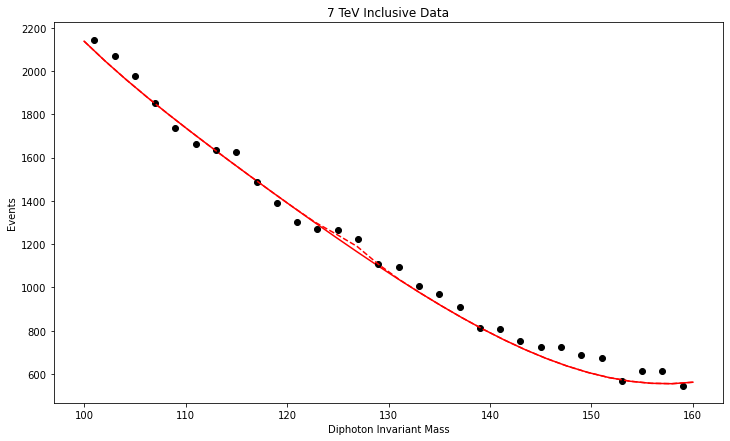

In [326]:
def total_background(x):
    return expsquared(x,*bkg_params[0]) + expsquared(x,*bkg_params[1]) + expsquared(x,*bkg_params[2]) + exponentialfit(x,*bkg_params[3]) + exponentialfit(x,*bkg_params[4]) + exponentialfit(x,*bkg_params[5]) + exponentialfit(x,*bkg_params[6]) + exponentialfit(x,*bkg_params[7]) + bernstein_combo(x,*bkg_params[8]) + bernstein_combo(x,*bkg_params[8])


barheights = np.histogram(inclusive7,bins = 30)

def total_signal(x):
    a = ratios[0]*(Nd[0]/35251)*50*5.9*gauss_sum(x,scb[0],sg[0])
    b = ratios[4]*(Nd[4]/35251)*50*5.9*gauss_sum(x,scb[4],sg[4])
    c = ratios[8]*(Nd[8]/35251)*50*5.9*gauss_sum(x,scb[8],sg[8])
    d = ratios[1]*(Nd[1]/35251)*50*5.9*gauss_sum(x,scb[1],sg[1])
    f = ratios[3]*(Nd[3]/35251)*50*5.9*gauss_sum(x,scb[3],sg[3])
    g = ratios[5]*(Nd[5]/35251)*50*5.9*gauss_sum(x,scb[5],sg[5])
    h = ratios[7]*(Nd[7]/35251)*50*5.9*gauss_sum(x,scb[7],sg[7])
    k = ratios[9]*(Nd[9]/35251)*50*5.9*gauss_sum(x,scb[9],sg[9])
    m = ratios[2]*(Nd[2]/35251)*50*5.9*gauss_sum(x,scb[2],sg[2])
    n = ratios[6]*(Nd[6]/35251)*50*5.9*gauss_sum(x,scb[6],sg[6])
    return a + b + c + d + f + g + h + k + m + n 

fig,ax = plt.subplots(figsize = [12,7])
ax.plot(np.linspace(100,160,30),total_background(np.linspace(100,160,30)),'r-')
ax.plot(np.linspace(101,159,30),barheights[0],'ok')
ax.plot(np.linspace(100,160,30),total_signal(np.linspace(100,160,30)) + total_background(np.linspace(100,160,30)),'r--')
ax.set_title('7 TeV Inclusive Data')
ax.set_xlabel('Diphoton Invariant Mass')
ax.set_ylabel('Events')

In [317]:
bh7 = barheights[0]
tb7 = total_background(np.linspace(100,160,30))
sb7 = total_signal(np.linspace(100,160,30)) + total_background(np.linspace(100,160,30))
s7 = total_signal(np.linspace(100,160,30))

In [327]:
bh8 = barheights[0]
tb8 = total_background(np.linspace(100,160,30))
sb8 = total_signal(np.linspace(100,160,30)) + total_background(np.linspace(100,160,30))
s8 = total_signal(np.linspace(100,160,30))

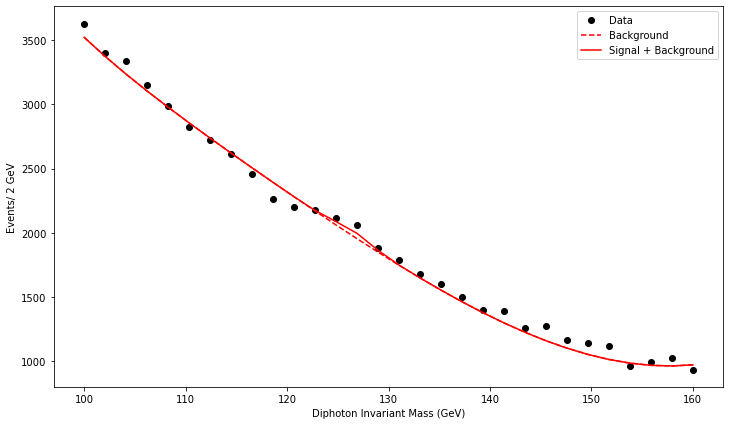

In [328]:
bh_total = [bh7[y] + bh8[y] for y in range(len(bh7))]
ms = np.linspace(100,160,30)
fig,ax = plt.subplots(figsize=[12,7])
ax.plot(ms,bh_total,'ok')
ax.plot(ms,tb7 + tb8,'r--')
ax.plot(ms,sb7 + sb8,'r-')
ax.set_xlabel('Diphoton Invariant Mass (GeV)')
ax.set_ylabel('Events/ 2 GeV')
ax.legend(['Data','Background','Signal + Background'])

Text(0, 0.5, 'Events/2GeV - Background')

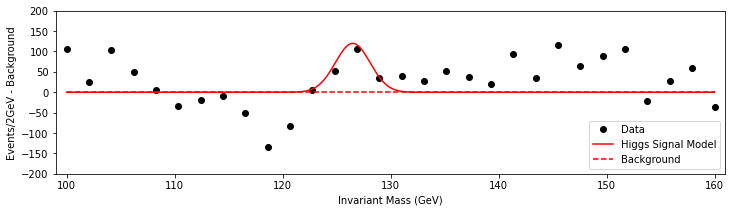

In [355]:
fig,ax = plt.subplots(figsize=[12,3])
just_sig = []
for y in range(len(bh_total)):
    diff = bh_total[y] - tb7[y] - tb8[y]
    just_sig.append(diff)
ax.plot(ms,just_sig,'ok')
ax.plot(np.linspace(100,160,500),(39*4.8 + 50*5.9)*gauss_sum(np.linspace(100,160,500),1.6,3.9/2.355),'r-')
ax.plot(ms,np.zeros([30,1]),'r--')
ax.set_ylim(-200,200)
ax.legend(['Data', 'Higgs Signal Model','Background'],loc = 'lower right')
ax.set_xlim(99,161)
ax.set_xlabel('Invariant Mass (GeV)')
ax.set_ylabel('Events/2GeV - Background')

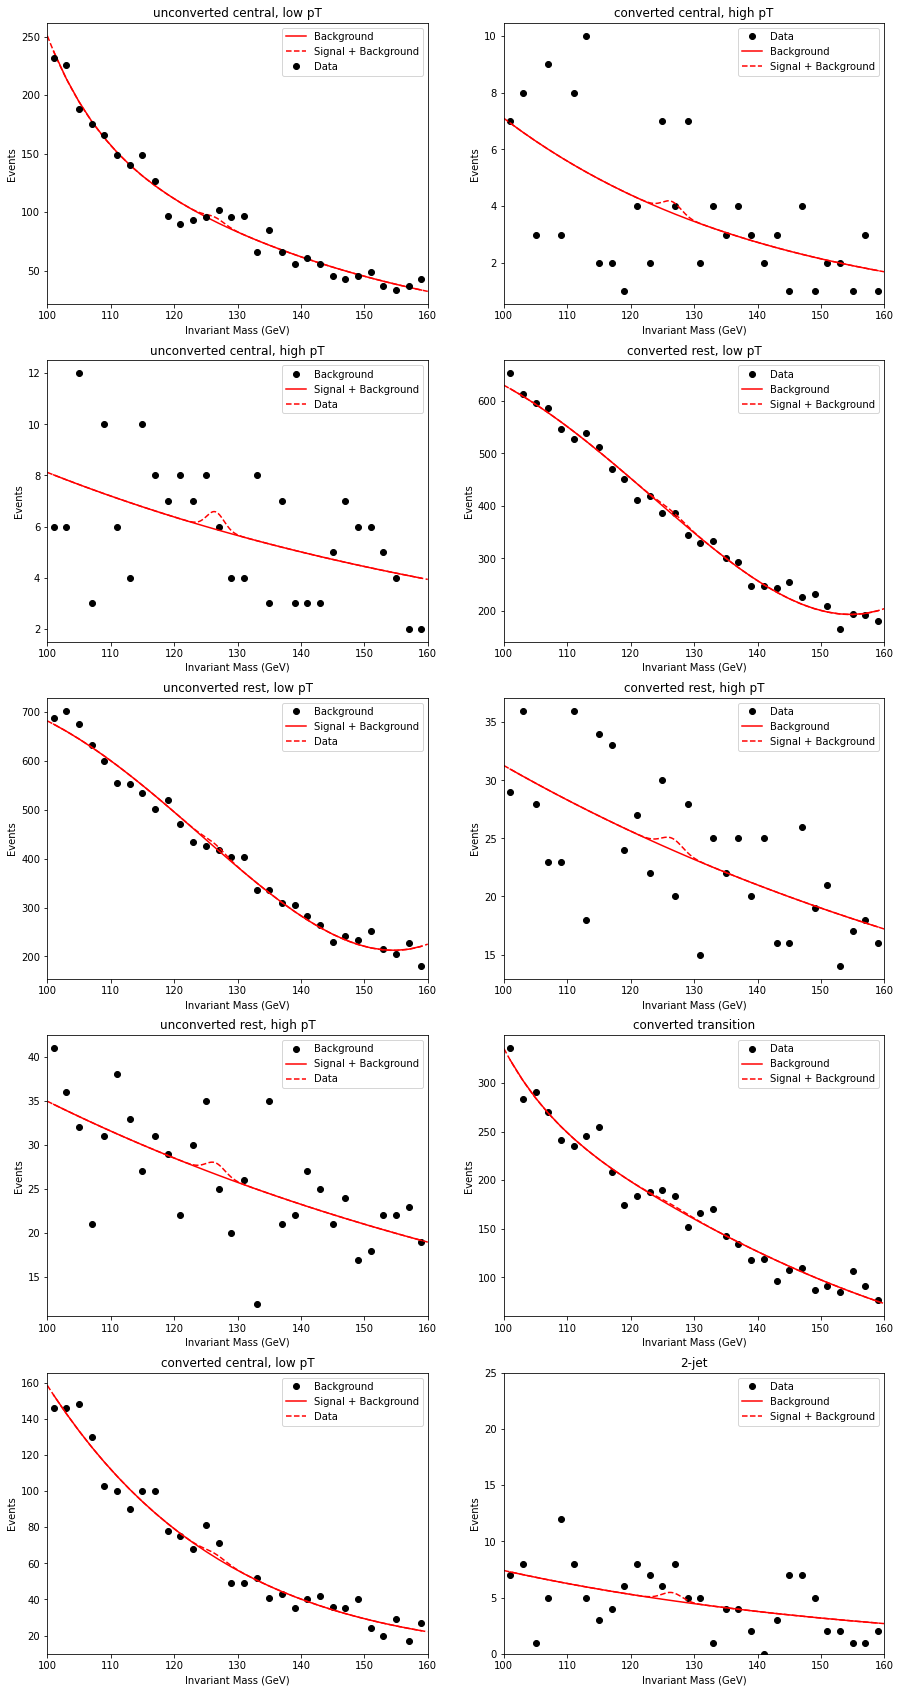

In [246]:
fig,ax = plt.subplots(5,2,figsize = [15,30])

# plot all the expoly plots

ax[0,0].plot(bincentersexpo,expsquared(bincenters,*bkg_params[0]),'r-')
ax[0,0].plot(np.linspace(100,160,500),ratios[0]*(Nd[0]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[0],sg[0]) + expsquared(np.linspace(100,160,500),*bkg_params[0]),'r--')
ax[0,0].plot(bincentersexpo,heightslist[0][0],'ko')
ax[0,0].set_title('unconverted central, low pT')
ax[0,0].set_xlabel('Invariant Mass (GeV)')
ax[0,0].set_xlim(100,160)

ax[4,0].plot(bincentersexpo,heightslist[1][0],'ko')
ax[4,0].plot(bincentersexpo,expsquared(bincenters,*bkg_params[1]),'r-')
ax[4,0].plot(np.linspace(100,160,500),ratios[4]*(Nd[4]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[4],sg[4]) + expsquared(np.linspace(100,160,500),*bkg_params[1]),'r--')
ax[4,0].set_xlabel('Invariant Mass (GeV)')
ax[4,0].set_title('converted central, low pT')
ax[4,0].set_xlim(100,160)

ax[3,1].plot(bincentersexpo,heightslist[2][0],'ko')
ax[3,1].plot(bincentersexpo,expsquared(bincenters,*bkg_params[2]),'r-')
ax[3,1].plot(np.linspace(100,160,500),ratios[8]*(Nd[8]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[8],sg[8]) + expsquared(np.linspace(100,160,500),*bkg_params[2]),'r--')
ax[3,1].set_xlabel('Invariant Mass (GeV)')
ax[3,1].set_title('converted transition')
ax[3,1].set_xlim(100,160)

#plot all the exponential plots

ax[1,0].plot(bincenters,heightslist[3][0],'ko')
ax[1,0].plot(bincenters,exponentialfit(bincenters,*bkg_params[3]),'r-')
ax[1,0].plot(np.linspace(100,160,500),ratios[1]*(Nd[1]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[1],sg[1]) + exponentialfit(np.linspace(100,160,500),*bkg_params[3]),'r--')
ax[1,0].set_title('unconverted central, high pT')
ax[1,0].set_xlabel('Invariant Mass (GeV)')
ax[1,0].set_xlim(100,160)

ax[3,0].plot(bincenters,heightslist[4][0],'ko')
ax[3,0].plot(bincenters,exponentialfit(bincenters,*bkg_params[4]),'r-')
ax[3,0].plot(np.linspace(100,160,500),ratios[3]*(Nd[3]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[3],sg[3]) + exponentialfit(np.linspace(100,160,500),*bkg_params[4]),'r--')
ax[3,0].set_title('unconverted rest, high pT')
ax[3,0].set_xlabel('Invariant Mass (GeV)')
ax[3,0].set_xlim(100,160)

ax[0,1].plot(bincenters,heightslist[5][0],'ko')
ax[0,1].plot(bincenters,exponentialfit(bincenters,*bkg_params[5]),'r-')
ax[0,1].plot(np.linspace(100,160,500),ratios[5]*(Nd[5]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[5],sg[5]) + exponentialfit(np.linspace(100,160,500),*bkg_params[5]),'r--')
ax[0,1].set_xlabel('Invariant Mass (GeV)')
ax[0,1].set_title('converted central, high pT')
ax[0,1].set_xlim(100,160)

ax[2,1].plot(bincenters,heightslist[6][0],'ko')
ax[2,1].plot(bincenters,exponentialfit(bincenters,*bkg_params[6]),'r-')
ax[2,1].plot(np.linspace(100,160,500),ratios[7]*(Nd[7]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[7],sg[7]) + exponentialfit(np.linspace(100,160,500),*bkg_params[6]),'r--')
ax[2,1].set_xlabel('Invariant Mass (GeV)')
ax[2,1].set_title('converted rest, high pT')
ax[2,1].set_xlim(100,160)

ax[4,1].plot(bincenters,heightslist[7][0],'ko')
ax[4,1].plot(bincenters,exponentialfit(bincenters,*bkg_params[7]),'r-')
ax[4,1].plot(np.linspace(100,160,500),ratios[9]*(Nd[9]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[9],sg[9]) + exponentialfit(np.linspace(100,160,500),*bkg_params[7]),'r--')
ax[4,1].set_xlabel('Invariant Mass (GeV)')
ax[4,1].set_title('2-jet')
ax[4,1].set_xlim(100,160)
ax[4,1].set_ylim(0,25)
#plot all the Bernstein polynomial plots

ax[2,0].plot(bincenters,heightslist[8][0],'ko')
ax[2,0].plot(bincenters,bernstein_combo(bincenters,*bkg_params[8]),'r-')
ax[2,0].plot(np.linspace(100,160,500),ratios[2]*(Nd[2]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[2],sg[2]) + bernstein_combo(np.linspace(100,160,500),*bkg_params[8]),'r--')
ax[2,0].set_xlabel('Invariant Mass (GeV)')
ax[2,0].set_title('unconverted rest, low pT')
ax[2,0].set_xlim(100,160)

ax[1,1].plot(bincenters,heightslist[9][0],'ko')
ax[1,1].plot(bincenters,bernstein_combo(bincenters,*bkg_params[9]),'r-')
ax[1,1].plot(np.linspace(100,160,500),ratios[6]*(Nd[6]/23788)*39*4.8*gauss_sum(np.linspace(100,160,500),scb[6],sg[6]) + bernstein_combo(np.linspace(100,160,500),*bkg_params[9]),'r--')
ax[1,1].set_xlabel('Invariant Mass (GeV)')
ax[1,1].set_title('converted rest, low pT')
ax[1,1].set_xlim(100,160)
    
for t in range(5):
    ax[t,0].set_ylabel('Events')
    ax[t,0].legend(['Background','Signal + Background','Data'])
    ax[t,1].set_ylabel('Events')
    ax[t,1].legend(['Data','Background','Signal + Background'])